# **Projet 6 : Classifiez automatiquement des biens de consommation - Classification supervisée image**

**Table des matières**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
  - 1.1. [Contexte](#toc1_1_)    
  - 1.2. [Mission](#toc1_2_)    
  - 1.3. [Objectif du Notebook](#toc1_3_)    
- 2. [Installation des librairies](#toc2_)    
- 3. [Importation des données](#toc3_)    
- 4. [Classification supervisée](#toc4_)    
  - 4.1. [Méthode sans data augmentation.](#toc4_1_)    
    - 4.1.1. [Classification CNN](#toc4_1_1_)    
    - 4.1.2. [Classification RandomForestClassifier](#toc4_1_2_)    
    - 4.1.3. [Classification KNNClassifier](#toc4_1_3_)    
  - 4.2. [Data augmentation avec ImageDataGenerator](#toc4_2_)    
    - 4.2.1. [Classification CNN](#toc4_2_1_)    
    - 4.2.2. [Classification RandomForestClassifier](#toc4_2_2_)    
    - 4.2.3. [Classification KNNClassifier](#toc4_2_3_)    
- 5. [Résultats](#toc5_)    
  - 5.1. [Erreurs de prédictions](#toc5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)
### 1.1. <a id='toc1_1_'></a>[Contexte](#toc0_)

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

Voici certaintes parties du mail envoyé par Linda.

### 1.2. <a id='toc1_2_'></a>[Mission](#toc0_)

1. Ta mission est de réaliser, dans une première itération, une étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

2. Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle.

3. Pourrais-tu tester la collecte de produits à base de “champagne” via l’API Rapid API ? Je souhaiterais que tu puisses nous fournir une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

### 1.3. <a id='toc1_3_'></a>[Objectif du Notebook](#toc0_)

Dans ce Notebook nous verrons :
- La classification supervisée des objets en se basant uniquement sur les images : 
    - Utilisation du meilleur modèle d'extraction de features de l'étude de faisabilité 
    - Classification à l'aide de trois méthodes : CNN (RestNet_512_V1), RandomForestClassifier et KNNClassifier
- La mise en place de cette classification en appliquant une Data augmentation sur les images

## 2. <a id='toc2_'></a>[Installation des librairies](#toc0_)

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model
from keras.applications import ResNet152

from fonctions import fct_data, fct_image, fct_clustering

## 3. <a id='toc3_'></a>[Importation des données](#toc0_)

In [2]:
data = fct_data.chargement_pickle(
    name='data_pretraite_image',
    chemin='2. Sauvegardes/2. IMAGE',
)

data.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                  image category_cleaned  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                        chemin_image  taille_image  \
0  1. Données/Images/55b85ea15a1536d46b7190ad6fff...      12960000   
1  1. Données/Images/7b72c92c2f6c40268628ec5f14c6...       3087684   
2  1. Données/Images/64d5d4a258243731dc7bbb1eef49...        715878   
3  1. Données/Images/d4684dcdc759dd9cdf41504698d7...        914100   
4  1. Données/Images/6325b6870c54cd47be6ebfbffa62...       5574960   

   largeur_image  hauteur_image  \
0           3600           3600   
1           2388           1293   
2            982            729   
3           1100            831   
4           2670           2088   

                             chemin_image_pretraitee  
0  2. Sauvegardes/2. IMAGE/Images traitées/55b85e...  
1  2. Sauvegardes/2. IMAGE/Images traitées/7b72c9...  
2  2. Sauvegardes/2. IMAGE/Images traitées/64d5d4...  
3  2. Sauvegardes/2. IMAGE/Images traitées/d4684d...  
4  2. Sauvegardes/2. IMAGE/Images traitées/6325b6...

In [3]:
# Modification des colonnes de data : 
data = data.drop(['description', 'taille_image', 'largeur_image',
                  'hauteur_image', 'chemin_image_pretraitee'],
                 axis =1,
                 )

data.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image category_cleaned  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                        chemin_image  
0  1. Données/Images/55b85ea15a1536d46b7190ad6fff...  
1  1. Données/Images/7b72c92c2f6c40268628ec5f14c6...  
2  1. Données/Images/64d5d4a258243731dc7bbb1eef49...  
3  1. Données/Images/d4684dcdc759dd9cdf41504698d7...  
4  1. Données/Images/6325b6870c54cd47be6ebfbffa62...

In [4]:
# Création d'un ensemble de train et d'un ensemble de test : 
data_train, data_test, _, _ = train_test_split(
    data,
    data['category_cleaned'],
    test_size=0.2,
    random_state=42,
    stratify=data['category_cleaned'],
)

# Affichage : 
print('++'*50 + '\nData Train - Répartition\n' + '++'*50)
display(data_train['category_cleaned'].value_counts())

print('++'*50 + '\nData Test - Répartition\n' + '++'*50)
display(data_test['category_cleaned'].value_counts())

del data

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Data Train - Répartition
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


category_cleaned
Home Furnishing               120
Computers                     120
Kitchen & Dining              120
Baby Care                     120
Home Decor & Festive Needs    120
Beauty and Personal Care      120
Watches                       120
Name: count, dtype: int64

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Data Test - Répartition
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


category_cleaned
Baby Care                     30
Beauty and Personal Care      30
Home Furnishing               30
Watches                       30
Home Decor & Festive Needs    30
Kitchen & Dining              30
Computers                     30
Name: count, dtype: int64

In [5]:
# Encodage des categories : 
le = LabelEncoder()

data_train['true_label'] = le.fit_transform(data_train['category_cleaned'])
data_test['true_label'] = le.transform(data_test['category_cleaned'])

display(data_train.head(5))

del le

# Création d'un dictionnaire de correspondance : 
dico_trad = {label: category for label, category in zip(data_train['true_label'], data_train['category_cleaned'])}
dico_trad = dict(sorted(dico_trad.items(), key=lambda item: item[0]))

display(dico_trad)


product_name  \
799                    Rajrang Animal Cushions Cover   
324  Huawei WS331c -300 Mbps Wireless Range Extender   
173                Rockmantra Water Fire Ceramic Mug   
391                                  Asus DSL-N10_C1   
670                               MH MDF Photo Frame   

                                    image  category_cleaned  \
799  5188dd28a627807407d93549580afb74.jpg   Home Furnishing   
324  a43fbae655e5d13215b9dd65339fa9d4.jpg         Computers   
173  6b043b37c38f081d96886acb5acfbdf5.jpg  Kitchen & Dining   
391  7fd12776e6d62da6e1dd3cbc9882ee5f.jpg         Computers   
670  d06bb04b096c77dc3302eaf2db336f96.jpg         Baby Care   

                                          chemin_image  true_label  
799  1. Données/Images/5188dd28a627807407d93549580a...           4  
324  1. Données/Images/a43fbae655e5d13215b9dd65339f...           2  
173  1. Données/Images/6b043b37c38f081d96886acb5acf...           5  
391  1. Données/Images/7fd12776e6d62da6e1dd3cbc9882...           2  
670  1. Données/Images/d06bb04b096c77dc3302eaf2db33...           0

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

In [6]:
# Enregistrement : 
fct_data.enregistrement_pickle(
    name='data_train',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=data_train,
)

fct_data.enregistrement_pickle(
    name='data_test',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=data_test,
)

fct_data.enregistrement_pickle(
    name='dico_trad_true_labels',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=dico_trad,
)

## 4. <a id='toc4_'></a>[Classification supervisée](#toc0_)
Pour la classification supervisée à partir des images, nous utiliserons trois méthode différente basé sur la meilleure extraction de features précédement observé lors des tests de faisabilités.  
C'est à dire que nous utiliserons le modèle CNN ResNet_512_v1. 

*Classification :*

|Méthode|Description|
|-|-|
|**Classification avec Réseau Neuronal (CNN)**|Utilisation de l'extraction de features de ResNet_512_v1 + utilisation de couche supérieurs personnalisées pour la classification.|
|**Classification avec RandomForest**|Utilisation de l'extraction de features de ResNet_512_v1 + classification avec RandomForestClassifier|
|**Classification avec KNN**|Utilisation de l'extraction de features de ResNet_512_v1 + classification avec KNNClassifier|


In [7]:
# Création d'un dictionnaire pour stocker les résultats : 
dict_image_class_supervisee = {}

### 4.1. <a id='toc4_1_'></a>[Méthode sans data augmentation.](#toc0_)
#### 4.1.1. <a id='toc4_1_1_'></a>[Classification CNN](#toc0_)

In [8]:
# Création du modèle : 
model = fct_image.creation_model_class_ResNet()

# Création d'un callback : 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [9]:
# Création des données train, validation et test : 

# 1. Préparation des images de data_train et data_test : 
X_train = fct_image.preparation_img_ResNet(
    chemin_image=data_train['chemin_image'],
)

X_test = fct_image.preparation_img_ResNet(
    chemin_image=data_test['chemin_image'],
)

# 2. Préparation des cibles train et test : 
y_test = data_test['true_label'].values
y_train = data_train['true_label'].values

# 3. Création des données de validation : 
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
    )

# 4. Encodage des cibles : 
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Affichage des résultats : 
print(f"Dimensions de X_train : {np.shape(X_train)}")
print(f"Dimensions de y_train : {np.shape(y_train)}")
print(f"Dimensions de X_val : {np.shape(X_val)}")
print(f"Dimensions de y_val : {np.shape(y_val)}")
print(f"Dimensions de X_test : {np.shape(X_test)}")
print(f"Dimensions de y_test : {np.shape(y_test)}")

/Users/maxime/anaconda3/envs/Projet6/lib/python3.11/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Dimensions de X_train : (672, 224, 224, 3)
Dimensions de y_train : (672, 7)
Dimensions de X_val : (168, 224, 224, 3)
Dimensions de y_val : (168, 7)
Dimensions de X_test : (210, 224, 224, 3)
Dimensions de y_test : (210, 7)


In [10]:
# Entrainement du modèle : 
history = model.fit(
    x=X_train, 
    y=y_train,
    epochs=50,
    batch_size=32,
    callbacks=es,
    validation_data=(X_val, y_val),  
    verbose=1,
)

Epoch 1/50


2023-10-11 15:04:40.489816: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - 350s 17s/step - loss: 1.7246 - accuracy: 0.6146 - val_loss: 0.6372 - val_accuracy: 0.7917
Epoch 2/50
21/21 [==============================] - 342s 16s/step - loss: 0.5612 - accuracy: 0.8244 - val_loss: 0.5989 - val_accuracy: 0.8155
Epoch 3/50
21/21 [==============================] - 404s 20s/step - loss: 0.3431 - accuracy: 0.8690 - val_loss: 0.5883 - val_accuracy: 0.8274
Epoch 4/50
21/21 [==============================] - 377s 18s/step - loss: 0.2727 - accuracy: 0.9107 - val_loss: 0.6135 - val_accuracy: 0.8333
Epoch 5/50
21/21 [==============================] - 345s 17s/step - loss: 0.2435 - accuracy: 0.9196 - val_loss: 0.5957 - val_accuracy: 0.8214
Epoch 6/50
21/21 [==============================] - 355s 17s/step - loss: 0.1868 - accuracy: 0.9449 - val_loss: 0.7303 - val_accuracy: 0.8214
Epoch 7/50
21/21 [==============================] - 364s 18s/step - loss: 0.1123 - accuracy: 0.9688 - val_loss: 0.7323 - val_accuracy: 0.8095
Epoch 8/50
21/21 

In [11]:
# Calcul des accuracy : 
accuracy_train = history.history['accuracy'][-1]
accuracy_val = history.history['val_accuracy'][-1]
_, accuracy_test = model.evaluate(x=X_test, y=y_test, verbose=1)

print(f"Training Accuracy: {accuracy_train*100:.2f}%")
print(f"Validation Accuracy:  {accuracy_val*100:.2f}%")
print(f"Test Accuracy:  {accuracy_test*100:.2f}%")

# Création du df avec les prédictions : 
y_pred_test = np.argmax(
    model.predict(X_test),
    axis=1,
    )

y_test = np.argmax(
    y_test,
    axis=1,
    )

# Création de df_test : 
df_test = pd.DataFrame(
    {
    'True_label': y_test,
    'Category_predict': y_pred_test,
    },
    )

Training Accuracy: 95.98%
Validation Accuracy:  83.93%
Test Accuracy:  85.71%
7/7 [==============================] - 87s 12s/step


In [14]:
# Complétion du dictionnaire : 
dict_image_class_supervisee['CNN_ResNet152v1_sans_DA'] = {
    'Accuracy_train': accuracy_train,
    'Accuracy_val': accuracy_val,
    'Accuracy_test': accuracy_test,
    'df_label': df_test,
}

# Enregistrement :
fct_data.enregistrement_pickle(
    name='dict_image_class_supervisee',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=dict_image_class_supervisee,
)

fct_data.enregistrement_pickle(
    name='history_CNN_sans_DA', 
    chemin='2. Sauvegardes/3. Classification supervisée images', 
    fichier=history,
)

model.save('2. Sauvegardes/3. Classification supervisée images/model_ResNet_sans_DA.h5')

del accuracy_test, accuracy_train, accuracy_val, df_test, y_pred_test
del es, history, model, X_test, X_train, X_val, y_test, y_train, y_val 

#### 4.1.2. <a id='toc4_1_2_'></a>[Classification RandomForestClassifier](#toc0_)
Ici, nous allons réaliser une extraction de features avec ResNet_152_v1 puis utiliser RandomForestClassifier pour la classification. 

In [19]:
# Extraction des features avec ResNet152v1 : 
X_train = fct_image.extraction_features_resnet152(
    chemin_image=data_train['chemin_image'],
    version='v1',
)

X_test = fct_image.extraction_features_resnet152(
    chemin_image=data_test['chemin_image'],
    version='v1',
)

# Création des cibles : 
y_test = data_test['true_label'].values
y_train = data_train['true_label'].values

Extraction des features:  90%|████████▉ | 755/840 [00:12<00:01, 71.52it/s]/Users/maxime/anaconda3/envs/Projet6/lib/python3.11/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Extraction des features: 100%|██████████| 840/840 [00:14<00:00, 59.17it/s]


27/27 [==============================] - 314s 12s/step


Extraction des features: 100%|██████████| 210/210 [00:09<00:00, 22.09it/s]


7/7 [==============================] - 83s 11s/step


In [20]:
# Entrainement de RandomForestClassifier : 

params = {
        'n_estimators': [300, 325, 350],
        'max_depth': [6, 7, 8],
    }

accuracy_train, accuracy_val, accuracy_test, y_pred_test, best_params = \
    fct_image.train_random_forest(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        params=params
    )

Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------------------------------------------------------------------------------------------------
Meilleure hyperparamètres pour RandomForestClassifier : {'max_depth': 7, 'n_estimators': 325}

Trainning Accuracy : 99.05%
Validation Accuracy : 82.26%
Test Accuracy : 80.00%


In [21]:
# Création de df_test : 
df_test = pd.DataFrame(
    {
    'True_label': y_test,
    'Category_predict': y_pred_test,
    },
    )

# Complétion du dictionnaire : 
dict_image_class_supervisee['RandomForest_sans_DA'] = {
    'Accuracy_train': accuracy_train,
    'Accuracy_val': accuracy_val,
    'Accuracy_test': accuracy_test,
    'df_label': df_test,
    'best_params_RFC': best_params,
}

# Enregistrement :
fct_data.enregistrement_pickle(
    name='dict_image_class_supervisee',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=dict_image_class_supervisee,
)

del X_train, y_train, X_test, y_test,
del params, accuracy_test, accuracy_train, accuracy_val, y_pred_test, best_params, df_test

#### 4.1.3. <a id='toc4_1_3_'></a>[Classification KNNClassifier](#toc0_)
Ici, nous allons réaliser une extraction de features avec ResNet_152_v5 puis utiliser RandomForestClassifier pour la classification. 

In [29]:
# Extraction des features avec ResNet152v1 : 
X_train = fct_image.extraction_features_resnet152(
    chemin_image=data_train['chemin_image'],
    version='v1',
)

X_test = fct_image.extraction_features_resnet152(
    chemin_image=data_test['chemin_image'],
    version='v1',
)

# Création des cibles : 
y_test = data_test['true_label'].values
y_train = data_train['true_label'].values

Extraction des features:  89%|████████▊ | 744/840 [00:09<00:01, 79.11it/s] /Users/maxime/anaconda3/envs/Projet6/lib/python3.11/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Extraction des features: 100%|██████████| 840/840 [00:11<00:00, 76.20it/s]


27/27 [==============================] - 399s 15s/step


Extraction des features: 100%|██████████| 210/210 [00:08<00:00, 26.18it/s]


7/7 [==============================] - 89s 12s/step


In [30]:
# Entrainnement de KNNClassifier : 

params = {
        'n_neighbors': [3, 4, 5, 6, 7, 8],
    }

accuracy_train, accuracy_val, accuracy_test, y_pred_test, best_params = \
    fct_image.train_knn(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        params=params
    )

Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------------------------------------------------------------------------------------------------
Meilleure hyperparamètres pour KNNClassififer : {'n_neighbors': 7}

Trainning Accuracy : 86.07%
Validation Accuracy : 76.31%
Test Accuracy : 72.38%


In [31]:
# Création de df_test : 
df_test = pd.DataFrame(
    {
    'True_label': y_test,
    'Category_predict': y_pred_test,
    },
    )

# Complétion du dictionnaire : 
dict_image_class_supervisee['KNNClassifier_sans_DA'] = {
    'Accuracy_train': accuracy_train,
    'Accuracy_val': accuracy_val,
    'Accuracy_test': accuracy_test,
    'df_label': df_test,
    'best_params_KNN': best_params,
}

# Enregistrement :
fct_data.enregistrement_pickle(
    name='dict_image_class_supervisee',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=dict_image_class_supervisee,
)

del X_train, y_train, X_test, y_test,
del params, accuracy_test, accuracy_train, accuracy_val, y_pred_test, best_params, df_test

### 4.2. <a id='toc4_2_'></a>[Data augmentation avec ImageDataGenerator](#toc0_)
Utilisation de ImageDataGenerator de Keras pour réaliser une Data augmentation sur les images
Data Augmentation pour le train et la validation uniquement. 

#### 4.2.1. <a id='toc4_2_1_'></a>[Classification CNN](#toc0_)

In [42]:
# Création du modèle : 
model = fct_image.creation_model_class_ResNet()

# Création d'un callback : 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Création des generator train, validation et test :
train_generator = fct_image.create_data_generator(
    dataframe=data_train, 
    subset='training',
)

validation_generator = fct_image.create_data_generator(
    dataframe=data_train,
    subset='validation',
)

test_generator = fct_image.create_data_generator(
    dataframe=data_test,
    subset=None,
)


Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [45]:
# Entrainement du modèle : 
history = model.fit(
    train_generator,
    epochs=50,    
    batch_size=32,
    callbacks=es, 
    validation_data=validation_generator,
    verbose=1,
)

Epoch 1/50


2023-10-11 17:32:38.967199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/21 [=======================>......] - ETA: 51s - loss: 1.5733 - accuracy: 0.5846 

/Users/maxime/anaconda3/envs/Projet6/lib/python3.11/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


21/21 [==============================] - ETA: 0s - loss: 1.4465 - accuracy: 0.6101 

2023-10-11 17:37:14.012861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


21/21 [==============================] - 549s 27s/step - loss: 1.4465 - accuracy: 0.6101 - val_loss: 0.7574 - val_accuracy: 0.7798
Epoch 2/50
21/21 [==============================] - 342s 16s/step - loss: 0.5941 - accuracy: 0.8185 - val_loss: 0.7725 - val_accuracy: 0.8155
Epoch 3/50
21/21 [==============================] - 367s 18s/step - loss: 0.4916 - accuracy: 0.8438 - val_loss: 0.8180 - val_accuracy: 0.7738
Epoch 4/50
21/21 [==============================] - 792s 17s/step - loss: 0.3951 - accuracy: 0.8795 - val_loss: 0.7108 - val_accuracy: 0.8095
Epoch 5/50
21/21 [==============================] - 472s 23s/step - loss: 0.2899 - accuracy: 0.9062 - val_loss: 1.0237 - val_accuracy: 0.7798
Epoch 6/50
21/21 [==============================] - 890s 44s/step - loss: 0.2524 - accuracy: 0.9167 - val_loss: 0.7985 - val_accuracy: 0.8095
Epoch 7/50
21/21 [==============================] - 339s 16s/step - loss: 0.1946 - accuracy: 0.9390 - val_loss: 0.9366 - val_accuracy: 0.8155
Epoch 8/50
21/21 

In [56]:
# Calcul des accuracy : 
accuracy_train = history.history['accuracy'][-1]
accuracy_val = history.history['val_accuracy'][-1]
_, accuracy_test = model.evaluate(test_generator, verbose=1)

print(f"Training Accuracy: {accuracy_train*100:.2f}%")
print(f"Validation Accuracy:  {accuracy_val*100:.2f}%")
print(f"Test Accuracy:  {accuracy_test*100:.2f}%")


# Création du df avec les prédictions : 
y_pred_test = np.argmax(
    model.predict(test_generator),
    axis=1,
    )

y_test = test_generator.classes

df_test = pd.DataFrame(
    {
    'True_label': y_test,
    'Category_predict': y_pred_test,
    },
    )

2023-10-11 19:09:12.144331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 78s 13s/step - loss: 0.9280 - accuracy: 0.8190
Training Accuracy: 93.60%
Validation Accuracy:  82.14%
Test Accuracy:  81.90%


2023-10-11 19:10:31.998783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 105s 15s/step


In [57]:
# Complétion du dictionnaire : 
dict_image_class_supervisee['CNN_ResNet152v1_DA_ImageDataGenerator'] = {
    'Accuracy_train': accuracy_train,
    'Accuracy_val': accuracy_val,
    'Accuracy_test': accuracy_test,
    'df_label': df_test,
}

# Enregistrement :
fct_data.enregistrement_pickle(
    name='dict_image_class_supervisee',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=dict_image_class_supervisee,
)

fct_data.enregistrement_pickle(
    name='history_CNN_DA_ImageDataGenerator', 
    chemin='2. Sauvegardes/3. Classification supervisée images', 
    fichier=history,
)

model.save('2. Sauvegardes/3. Classification supervisée images/model_ResNet_DA_ImageDataGenerator.h5')

del accuracy_test, accuracy_train, accuracy_val, df_test, y_pred_test
del es, history, model, train_generator, validation_generator, test_generator, y_test 

#### 4.2.2. <a id='toc4_2_2_'></a>[Classification RandomForestClassifier](#toc0_)

In [3]:
# 1. Création d'un modèle ResNeet_152_v1 pré-entrainé sans les couches supérieures : 
base_model = ResNet152(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# 2. Création des générateurs de données : 
train_generator = fct_image.create_data_generator(
    dataframe=data_train, 
    subset='train_RandomForest',
)

test_generator = fct_image.create_data_generator(
    dataframe=data_test,
    subset='test',
)
   
# 3. Récupération des features : 
features_train = model.predict(train_generator)
features_train = features_train.reshape(features_train.shape[0], -1)
features_test = model.predict(test_generator)
features_test = features_test.reshape(features_test.shape[0], -1)

# 4. Récupération des labels : 
labels_train = train_generator.classes
labels_test = test_generator.classes

del base_model, model

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


2023-10-11 19:28:37.089084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-11 19:28:37.107382: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 5/27 [====>.........................] - ETA: 6:05

/Users/maxime/anaconda3/envs/Projet6/lib/python3.11/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 [==============================] - 427s 16s/step


2023-10-11 19:35:44.878331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 84s 12s/step


In [4]:
# Entrainement de RandomForestClassifier : 

params = {
        'n_estimators': [150, 175, 200],
        'max_depth': [None, 1, 2, 3, 4, 5, 6],
    }

accuracy_train, accuracy_val, accuracy_test, y_pred_test, best_params = \
    fct_image.train_random_forest(
        X_train=features_train,
        X_test=features_test,
        y_train=labels_train,
        y_test=labels_test,
        params=params,
    )

Fitting 5 folds for each of 21 candidates, totalling 105 fits
----------------------------------------------------------------------------------------------------
Meilleure hyperparamètres pour RandomForestClassifier : {'max_depth': 4, 'n_estimators': 200}

Trainning Accuracy : 97.50%
Validation Accuracy : 16.90%
Test Accuracy : 13.33%


In [5]:
# Création de df_test : 
df_test = pd.DataFrame(
    {
    'True_label': labels_test,
    'Category_predict': y_pred_test,
    },
    )

# Complétion du dictionnaire : 
dict_image_class_supervisee['RandomForest_DA_ImageDataGenerator'] = {
    'Accuracy_train': accuracy_train,
    'Accuracy_val': accuracy_val,
    'Accuracy_test': accuracy_test,
    'df_label': df_test,
    'best_params_RFC': best_params,
}

# Enregistrement :
fct_data.enregistrement_pickle(
    name='dict_image_class_supervisee',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=dict_image_class_supervisee,
)

del train_generator, test_generator, features_test, features_train, labels_test, labels_train
del params, accuracy_test, accuracy_train, accuracy_val, y_pred_test, best_params, df_test

#### 4.2.3. <a id='toc4_2_3_'></a>[Classification KNNClassifier](#toc0_)

In [6]:
# 1. Création d'un modèle ResNeet_152_v1 pré-entrainé sans les couches supérieures : 
base_model = ResNet152(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# 2. Création des générateurs de données : 
train_generator = fct_image.create_data_generator(
    dataframe=data_train, 
    subset='train_Knn',
)

test_generator = fct_image.create_data_generator(
    dataframe=data_test,
    subset='test',
)
   
# 3. Récupération des features : 
features_train = model.predict(train_generator)
features_train = features_train.reshape(features_train.shape[0], -1)
features_test = model.predict(test_generator)
features_test = features_test.reshape(features_test.shape[0], -1)

# 4. Récupération des labels : 
labels_train = train_generator.classes
labels_test = test_generator.classes

del base_model, model

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


2023-10-11 19:52:23.753649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 5/27 [====>.........................] - ETA: 3:17

/Users/maxime/anaconda3/envs/Projet6/lib/python3.11/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 [==============================] - 337s 13s/step


2023-10-11 19:58:02.005843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 198s 30s/step


In [8]:
# Entrainement de KNNClassifier : 

params = {
        'n_neighbors': [18, 19, 20, 21],
    }

accuracy_train, accuracy_val, accuracy_test, y_pred_test, best_params = \
    fct_image.train_knn(
        X_train=features_train,
        X_test=features_test,
        y_train=labels_train,
        y_test=labels_test,
        params=params,
    )

Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------------------------------------------------------------------------------------------------
Meilleure hyperparamètres pour KNNClassififer : {'n_neighbors': 20}

Trainning Accuracy : 26.43%
Validation Accuracy : 16.31%
Test Accuracy : 16.67%


In [9]:
# Création de df_test : 
df_test = pd.DataFrame(
    {
    'True_label': labels_test,
    'Category_predict': y_pred_test,
    },
    )

# Complétion du dictionnaire : 
dict_image_class_supervisee['KNNClassifier_DA_ImageDataGenerator'] = {
    'Accuracy_train': accuracy_train,
    'Accuracy_val': accuracy_val,
    'Accuracy_test': accuracy_test,
    'df_label': df_test,
    'best_params_KNNC': best_params,
}

# Enregistrement :
fct_data.enregistrement_pickle(
    name='dict_image_class_supervisee',
    chemin='2. Sauvegardes/3. Classification supervisée images',
    fichier=dict_image_class_supervisee,
)

del train_generator, test_generator, features_test, features_train, labels_test, labels_train
del params, accuracy_test, accuracy_train, accuracy_val, y_pred_test, best_params, df_test

## 5. <a id='toc5_'></a>[Résultats](#toc0_)

In [2]:
# Chargement des données : 

dict_image_class_supervisee = fct_data.chargement_pickle(
    name='dict_image_class_supervisee',
     chemin='2. Sauvegardes/3. Classification supervisée images',
)

dico_trad = fct_data.chargement_pickle(
    name='dico_trad_true_labels',
    chemin='2. Sauvegardes/3. Classification supervisée images',
)

data = fct_data.chargement_pickle(
    name='data_pretraite_image',
    chemin='2. Sauvegardes/2. IMAGE',
)

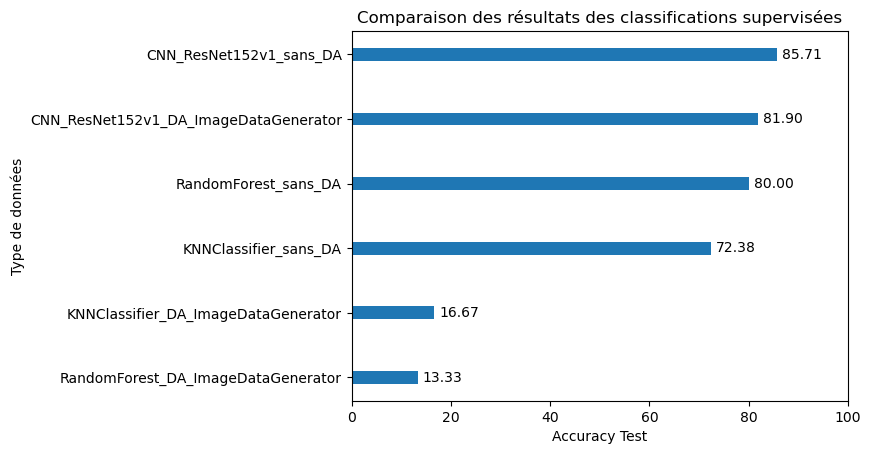

In [3]:
# Création du DataFrame de résultat :  
df = fct_image.df_result_class_supervisee(dict_image_class_supervisee)

# Affichage du graphique :

plt.figure()

bars = plt.barh(
    y=df.index,
    height=0.2,
    width=df['Accuracy_test'],
    )

for bar, accuracy in zip(bars, df['Accuracy_test']):
    plt.text(bar.get_width()+1, bar.get_y() + bar.get_height()/2, f'{accuracy:.2f}', ha='left', va='center')

plt.title('Comparaison des résultats des classifications supervisées')
plt.ylabel('Type de données')
plt.xlabel('Accuracy Test')
plt.xlim((0,100))
plt.gca().invert_yaxis()

plt.show()

Les meilleurs résultats sont obtenues à l'aide du modèle CNN sans data augmentation. 

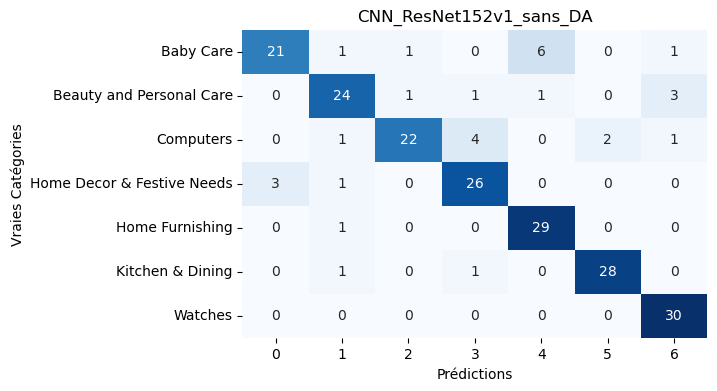

                            precision    recall  f1-score   support

                 Baby Care       0.88      0.70      0.78        30
  Beauty and Personal Care       0.83      0.80      0.81        30
                 Computers       0.92      0.73      0.81        30
Home Decor & Festive Needs       0.81      0.87      0.84        30
           Home Furnishing       0.81      0.97      0.88        30
          Kitchen & Dining       0.93      0.93      0.93        30
                   Watches       0.86      1.00      0.92        30

                  accuracy                           0.86       210
                 macro avg       0.86      0.86      0.85       210
              weighted avg       0.86      0.86      0.85       210



In [4]:
# Visualisation de la qualité du clustering pour CNN_ResNet152v1 sans data augmentation : 
df = dict_image_class_supervisee['CNN_ResNet152v1_sans_DA']['df_label']
df['Category_true'] = df['True_label'].map(dico_trad)

fct_clustering.qualite_categorisation(
    df=df,
    dico_trad=dico_trad,
    title='CNN_ResNet152v1_sans_DA',
)

### 5.1. <a id='toc5_1_'></a>[Erreurs de prédictions](#toc0_)

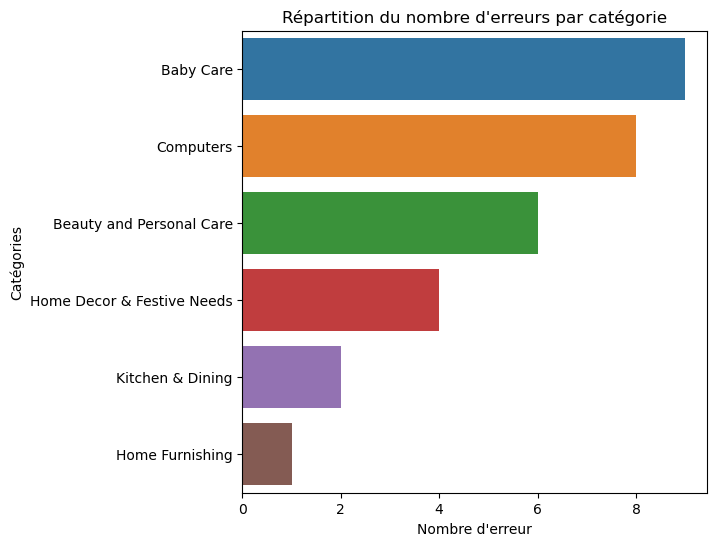

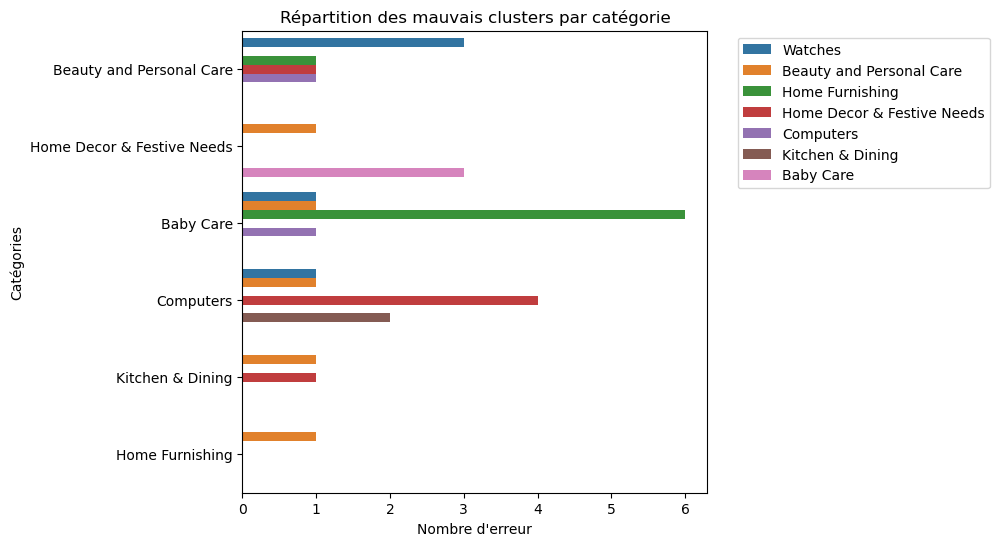

Les plus grosses erreurs sont dues au clusturing de Home Furnishing


In [5]:
fct_clustering.repartition_erreurs(
    df=df,
    dico_trad=dico_trad,
)

product_name  \
0             Elite Collection Medium Acrylic Sticker   
1       cherry crumble california Baby Boy's Dungaree   
2                 Piyo Piyo Four Stage Waterproof Bib   
3         Borse N16 Make Up And Jewellery Vanity Case   
4   Artist Haat Vanity Box Makeup and Jewellery Va...   
5   Oxyglow Golden Glow Radiance Anti Acne Facial ...   
6                      Homec Geometric Cushions Cover   
7                               IWS Cotton Bath Towel   
8                     Sapatos Plain Single Duvet Blue   
9   Times 317TMS317 Party-Wedding Analog Watch  - ...   
10       Fighter FIGH_008 Digital Watch  - For Couple   
11   Marvel DW100243 Digital Watch  - For Boys, Girls   
12  AsiaCraft Goddess of Wealth Laxmi Brass Statue...   
13  Wallmantra Abstract Colors Modern Art Wall Han...   
14  Unique Design Handcrafted Brass Mini Chair Tab...   
15            Prithish Never Ever Give Up Ceramic Mug   
16                  JayEnterprise Plastic Hand Juicer   
17  GAYATRI CREATIONS ORANGE KIDS SET 2 Containers...   
18  Task Logistics Audio Receiver H-366 USB Bluetooth   
19  PRINT SHAPES Red bull Laptop Skin with Mouse p...   
20             RRP Born To Have Lxs-001 USB Led Light   

                                          description  \
0   Buy Elite Collection Medium Acrylic Sticker fo...   
1   Key Features of cherry crumble california Baby...   
2   Specifications of Piyo Piyo Four Stage Waterpr...   
3   Buy Borse N16 Make Up And Jewellery Vanity Cas...   
4   Artist Haat Vanity Box Makeup and Jewellery Va...   
5   Buy Oxyglow Golden Glow Radiance Anti Acne Fac...   
6   Homec Geometric Cushions Cover (Pack of 10, 40...   
7   Buy IWS Cotton Bath Towel at Rs. 299 at Flipka...   
8   Sapatos Plain Single Duvet Blue (1 Piece Brown...   
9   Times 317TMS317 Party-Wedding Analog Watch  - ...   
10  Fighter FIGH_008 Digital Watch  - For Couple -...   
11  Marvel DW100243 Digital Watch  - For Boys, Gir...   
12  Buy AsiaCraft Goddess of Wealth Laxmi Brass St...   
13  Buy Wallmantra Abstract Colors Modern Art Wall...   
14  Buy Unique Design Handcrafted Brass Mini Chair...   
15  Prithish Never Ever Give Up Ceramic Mug (330 m...   
16  Specifications of JayEnterprise Plastic Hand J...   
17  Specifications of GAYATRI CREATIONS ORANGE KID...   
18  Buy Task Logistics Audio Receiver H-366 USB Bl...   
19  Key Features of PRINT SHAPES Red bull Laptop S...   
20  RRP Born To Have Lxs-001 USB Led Light (Purple...   

                                   image               category_true  \
0   3b465b02720ef7c930cb2e065a8fc05d.jpg                   Baby Care   
1   a8ea6fc2b3cd95f46bced80853ce8e0e.jpg                   Baby Care   
2   4e03d4e81e6a876f512536f6a57c053e.jpg                   Baby Care   
3   24e85c590481a7cedfe66597f253f2b2.jpg    Beauty and Personal Care   
4   edb97bd2433fd9de301c8a44344777bb.jpg    Beauty and Personal Care   
5   9993de7e2bcced43dc9edb3b2c81f23d.jpg    Beauty and Personal Care   
6   d218c32df572e82db50faecd62179db2.jpg             Home Furnishing   
7   72db37ec42ee76d79cf395221e0f4cce.jpg             Home Furnishing   
8   a371cfcae8c6ec3b82ae37a83a8ae9b9.jpg             Home Furnishing   
9   c8c7385b1b9589f009aa836f0590e646.jpg                     Watches   
10  e80e5151787eb21b0cca0d7dc3b0c338.jpg                     Watches   
11  788dc3a3da91c0f46a7c465e07f91dd4.jpg                     Watches   
12  6c441a6ca8eb4e5ca882c9c0df03ff0c.jpg  Home Decor & Festive Needs   
13  07912328f580cf080d721e6466287896.jpg  Home Decor & Festive Needs   
14  a4d9e71172f619f8e3122e34bb0bf3cc.jpg  Home Decor & Festive Needs   
15  a341f915962ee99754e962520f279708.jpg            Kitchen & Dining   
16  2971287a1ac427bd98c4778112d20d06.jpg            Kitchen & Dining   
17  5a7a1287fef0d986a5e237797beee286.jpg            Kitchen & Dining   
18  2c475daafe597ed93c1e27fcaa38d8cc.jpg                   Computers   
19  5a54c78b52c984e56500809e5bc27ae1.jpg                   Computers   
20  812bfd40e47dfde

----------------------------------------------------------------------------------------------------
Produit 0 :
Nom du produit : Elite Collection Medium Acrylic Sticker
Catégorie réelle : Baby Care
Catégorie prédite : Home Decor & Festive Needs


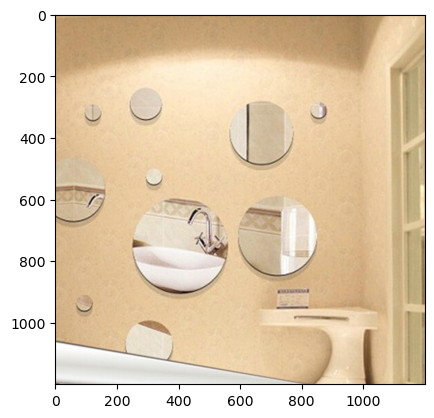

----------------------------------------------------------------------------------------------------
Produit 1 :
Nom du produit : cherry crumble california Baby Boy's Dungaree
Catégorie réelle : Baby Care
Catégorie prédite : Computers


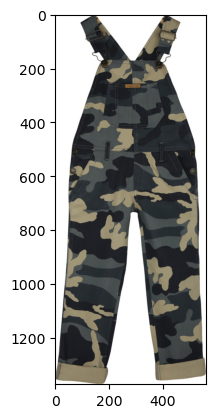

----------------------------------------------------------------------------------------------------
Produit 2 :
Nom du produit : Piyo Piyo Four Stage Waterproof Bib
Catégorie réelle : Baby Care
Catégorie prédite : Watches


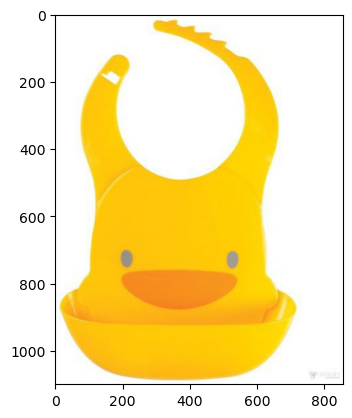

----------------------------------------------------------------------------------------------------
Produit 3 :
Nom du produit : Borse N16 Make Up And Jewellery Vanity Case
Catégorie réelle : Beauty and Personal Care
Catégorie prédite : Baby Care


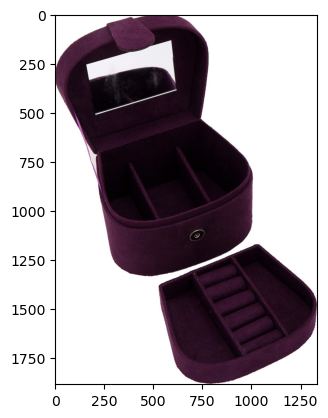

----------------------------------------------------------------------------------------------------
Produit 4 :
Nom du produit : Artist Haat Vanity Box Makeup and Jewellery Vanity Jewellery
Catégorie réelle : Beauty and Personal Care
Catégorie prédite : Baby Care


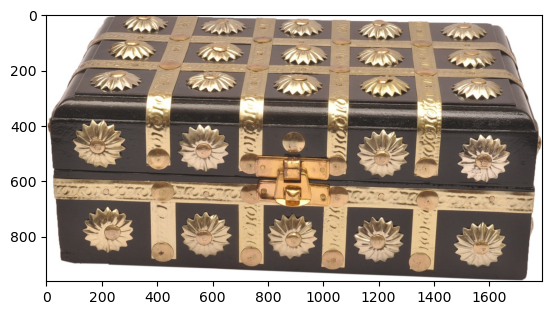

----------------------------------------------------------------------------------------------------
Produit 5 :
Nom du produit : Oxyglow Golden Glow Radiance Anti Acne Facial Kit & Fruit Massage Cream With Vitamin-E 200gm
Catégorie réelle : Beauty and Personal Care
Catégorie prédite : Baby Care


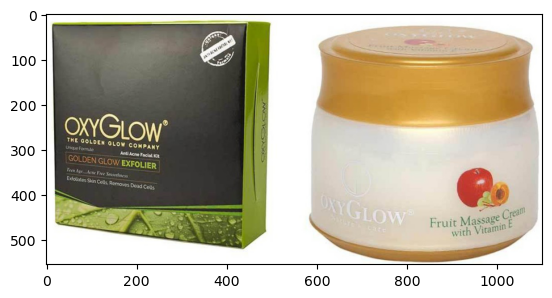

----------------------------------------------------------------------------------------------------
Produit 6 :
Nom du produit : Homec Geometric Cushions Cover
Catégorie réelle : Home Furnishing
Catégorie prédite : Baby Care


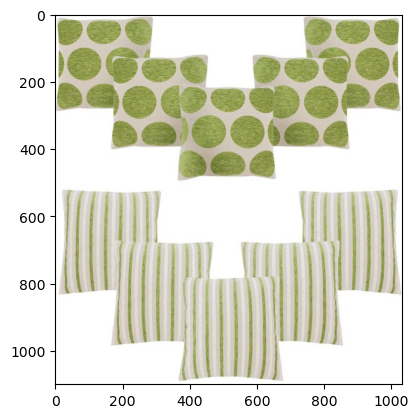

----------------------------------------------------------------------------------------------------
Produit 7 :
Nom du produit : IWS Cotton Bath Towel
Catégorie réelle : Home Furnishing
Catégorie prédite : Baby Care


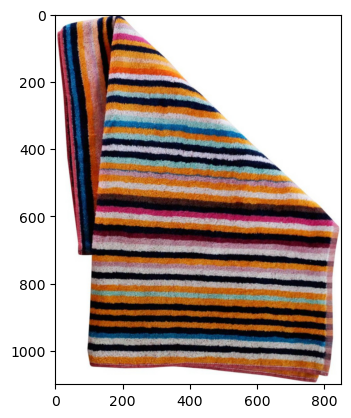

----------------------------------------------------------------------------------------------------
Produit 8 :
Nom du produit : Sapatos Plain Single Duvet Blue
Catégorie réelle : Home Furnishing
Catégorie prédite : Watches


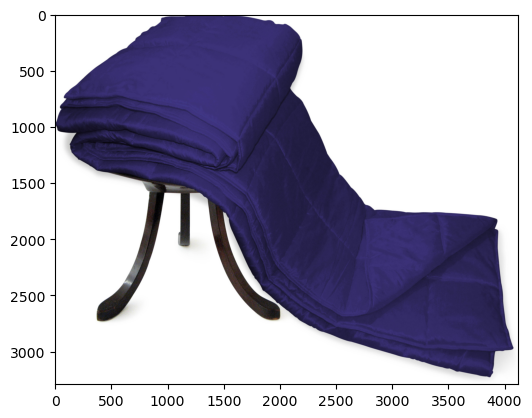

----------------------------------------------------------------------------------------------------
Produit 9 :
Nom du produit : Times 317TMS317 Party-Wedding Analog Watch  - For Men
Catégorie réelle : Watches
Catégorie prédite : Baby Care


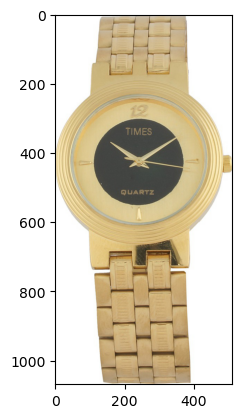

----------------------------------------------------------------------------------------------------
Produit 10 :
Nom du produit : Fighter FIGH_008 Digital Watch  - For Couple
Catégorie réelle : Watches
Catégorie prédite : Baby Care


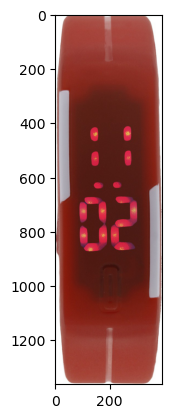

----------------------------------------------------------------------------------------------------
Produit 11 :
Nom du produit : Marvel DW100243 Digital Watch  - For Boys, Girls
Catégorie réelle : Watches
Catégorie prédite : Baby Care


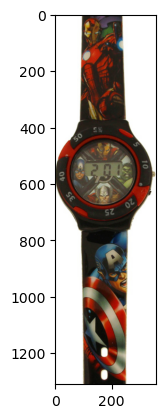

----------------------------------------------------------------------------------------------------
Produit 12 :
Nom du produit : AsiaCraft Goddess of Wealth Laxmi Brass Statue Showpiece  -  7.62 cm
Catégorie réelle : Home Decor & Festive Needs
Catégorie prédite : Baby Care


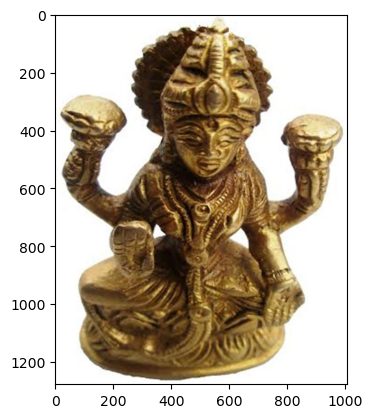

----------------------------------------------------------------------------------------------------
Produit 13 :
Nom du produit : Wallmantra Abstract Colors Modern Art Wall Hanging Canvas Painting
Catégorie réelle : Home Decor & Festive Needs
Catégorie prédite : Baby Care


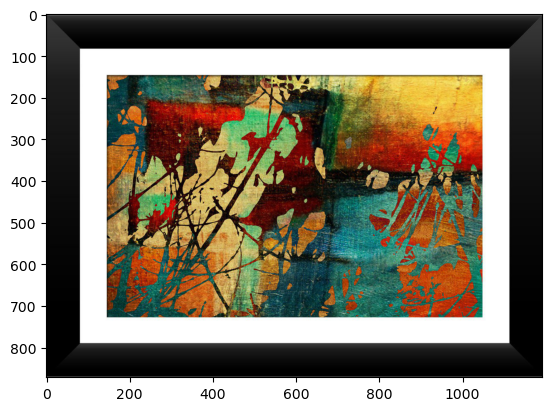

----------------------------------------------------------------------------------------------------
Produit 14 :
Nom du produit : Unique Design Handcrafted Brass Mini Chair Table Set Showpiece  -  10 cm
Catégorie réelle : Home Decor & Festive Needs
Catégorie prédite : Kitchen & Dining


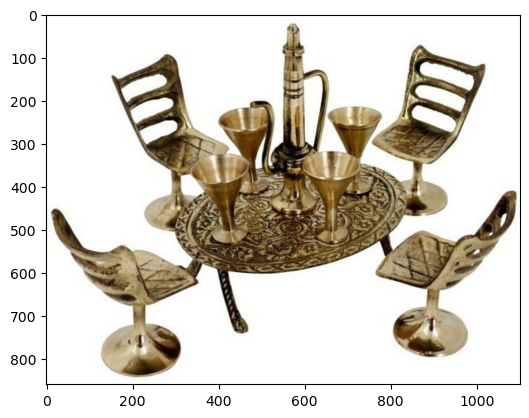

----------------------------------------------------------------------------------------------------
Produit 15 :
Nom du produit : Prithish Never Ever Give Up Ceramic Mug
Catégorie réelle : Kitchen & Dining
Catégorie prédite : Baby Care


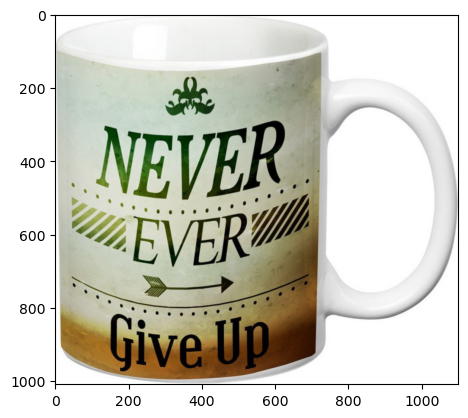

----------------------------------------------------------------------------------------------------
Produit 16 :
Nom du produit : JayEnterprise Plastic Hand Juicer
Catégorie réelle : Kitchen & Dining
Catégorie prédite : Watches


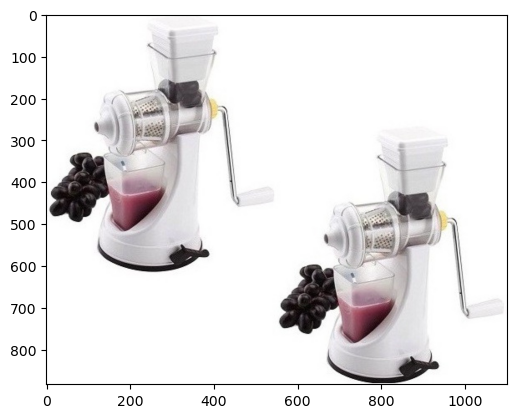

----------------------------------------------------------------------------------------------------
Produit 17 :
Nom du produit : GAYATRI CREATIONS ORANGE KIDS SET 2 Containers Lunch Box
Catégorie réelle : Kitchen & Dining
Catégorie prédite : Home Decor & Festive Needs


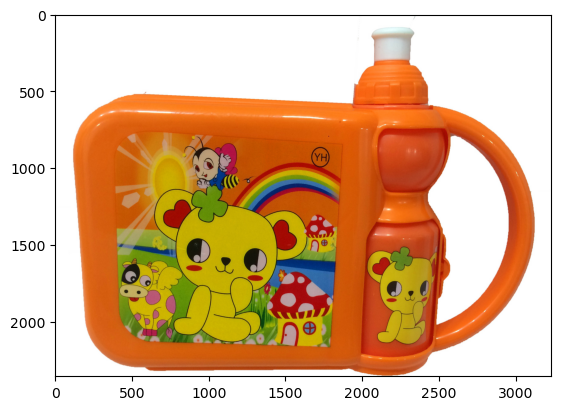

----------------------------------------------------------------------------------------------------
Produit 18 :
Nom du produit : Task Logistics Audio Receiver H-366 USB Bluetooth
Catégorie réelle : Computers
Catégorie prédite : Beauty and Personal Care


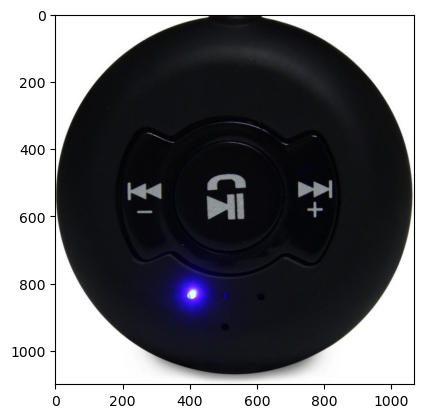

----------------------------------------------------------------------------------------------------
Produit 19 :
Nom du produit : PRINT SHAPES Red bull Laptop Skin with Mouse pad Combo Set
Catégorie réelle : Computers
Catégorie prédite : Watches


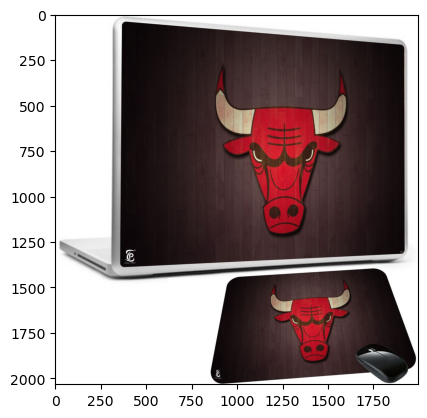

----------------------------------------------------------------------------------------------------
Produit 20 :
Nom du produit : RRP Born To Have Lxs-001 USB Led Light
Catégorie réelle : Computers
Catégorie prédite : Baby Care


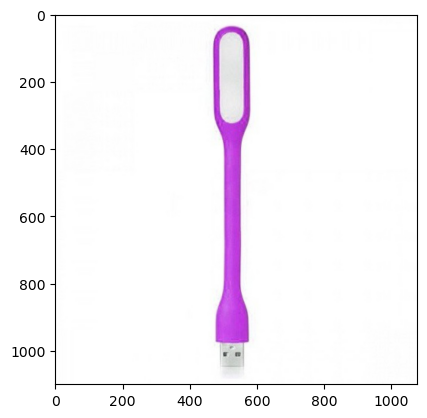

In [10]:
# Visualisation des descriptions de 3 produits par catégories avec une mauvaise classification : 

df = df.set_index(data_test.index)

fct_clustering.dataframe_comp_result(
    df_init=data,
    df_categ=df,
    dico_trad=dico_trad,
    chemin='1. Données/Images',
    type='image',
    )